Intro: <br>
The goal of this notebook is to determine the importance of the features in the data. <br>
The features are: Device, Hour, and Segments. 

In [96]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [97]:
data = pd.read_csv('campaign_data.csv')

          hour  segments  device_num
Variance  23.0     340.0    0.636529


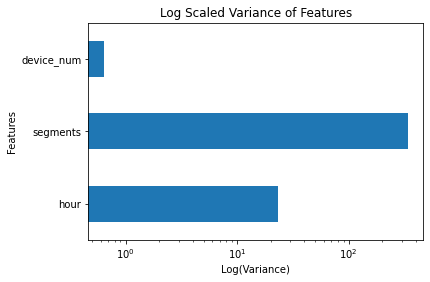

In [98]:
X = data[['hour', 'segments', 'device']]
y = data['result']

# feature selection by variance
from sklearn.feature_selection import VarianceThreshold

# only works with numerical data, so we will change 'device' to numerical values
X['device_num'] = X['device'].replace(['Smartphone', 'Tablet', 'Desktop'], [0, 1, 2])
X = X.drop(columns='device')

# default drops features where variance is 0
sel = VarianceThreshold()
sel.fit_transform(X, y)

# features leftover after dropping
selected_features = X[X.columns[sel.get_support(indices=True)]].columns

# variances with features
variances = pd.Series(sel.variances_, X.columns)

df = pd.DataFrame(data=variances).T
df.index = ['Variance']
print(df)

variances.plot(kind='barh')
plt.xscale('log')
plt.xlabel('Log(Variance)')
plt.ylabel('Features')
plt.title('Log Scaled Variance of Features')
plt.show()

# 'Device' only has 5 categories, thus it's supposed to have a low variance
# 'Segments' and 'Hour' are numerical, so they have much more.
# There's decent variance across each feature in the data.

                              hour  segments  device_num
Mutual Information Value  0.045394       0.0    0.022722


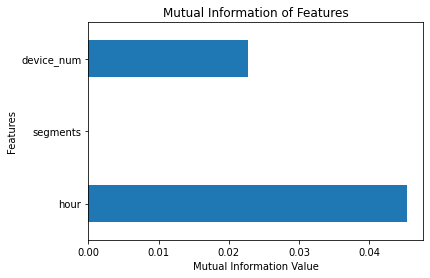

In [99]:
# information gain by feature:
# can capture any kind of statistical dependency, but being nonparametric,
# they require more samples for accurate estimation
# Higher value means higher dependency
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns)

df = pd.DataFrame(data=feat_importances).T
df.index = ['Mutual Information Value']
print(df)

feat_importances.plot(kind='barh')
plt.xlabel('Mutual Information Value')
plt.ylabel('Features')
plt.title('Mutual Information of Features')
plt.show()

# Since 'hour' has the highest value, it provides the most information for 'result'
# Followed by 'device'
# While 'segments' provides no information to 'result'

                   hour  segments    device_num
ANOVA F-Value  3.313889  0.133875  3.421729e+01
P-value        0.068787  0.714471  5.408784e-09


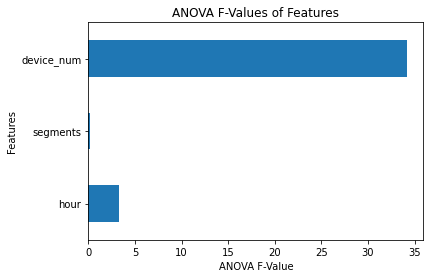

In [100]:
# Feature selection based on ANOVA F-test:
# estimates the degree of linear dependency between two random variables.
# ANOVA F-value: variation between sample means/variation within the samples
from sklearn.feature_selection import f_classif

anova = f_classif(X, y)
f_vals = pd.Series(anova[0], X.columns)

df = pd.DataFrame(data = anova, columns = X.columns, index=['ANOVA F-Value', 'P-value'])
print(df)

f_vals.plot(kind='barh')
plt.xlabel('ANOVA F-Value')
plt.ylabel('Features')
plt.title('ANOVA F-Values of Features')
plt.show()

# With a confidence level of .05, only 'devices' p-value is < .05
# We can accept the null hypothesis: for 'device' is significant in explaining the variance
#   of the 'result'
# 'hour' is close to the alpha to accept the null. 
# 'segments' is far from the alpha, thus it is not significant in explaining 'result'

              hour  segments    device_num
chi2     10.945453  9.004064  2.626522e+01
P-value   0.000938  0.002694  2.976007e-07


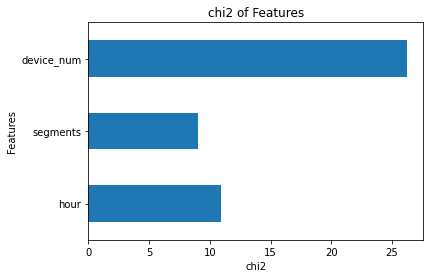

In [101]:
# Feature selection by chi2 scores
# low value means: high correlation between features and y
from sklearn.feature_selection import chi2

c = chi2(X, y)
stats = pd.Series(c[0], X.columns)

df = pd.DataFrame(data=c, columns = X.columns, index = ['chi2', 'P-value'])
print(df)

stats.plot(kind='barh')
plt.xlabel('chi2')
plt.ylabel('Features')
plt.title('chi2 of Features')
plt.show()

# All null hypothesis can be accepted
# 'device' is most correlated to 'result'
# 'hour' is second-most
# 'segments' is last

In [102]:
# RFE: Feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel="linear")
selector = RFE(estimator)
selector = selector.fit(X, y)

df = pd.DataFrame(data=[selector.ranking_], columns = X.columns, index=['Ranking'])
df

# 'Device' is most important, followed by 'Segments', then 'Hour' 

,hour,segments,device_num
Ranking,3,2,1


In [103]:
# RFE + CV to find optimal features

from sklearn.feature_selection import RFECV

estimator = SVC(kernel="linear")
selector = RFECV(estimator, cv=5)
selector = selector.fit(X, y)

df = pd.DataFrame(data=[selector.ranking_], columns = X.columns, index=['Ranking'])
df

# Same results as above.
# We can use RFE with different models as well.

,hour,segments,device_num
Ranking,3,2,1


In [122]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)

selector.estimator_.coef_

df = pd.DataFrame(data=selector.estimator_.coef_, columns = X.columns, index=['Coefficient'])
df

# Coefficients close to 0 in LR, mean that it is a small predictor.
# 'Device' is the biggest predictor, followed by 'hour', and 'segment' is near 0

,hour,segments,device_num
Coefficient,-0.008789,0.000142,-0.252342


Conclusion: <br>

In all of the tests above, we saw that 'device' held the best scores in predicting 'result'.
There were some tests where 'segments' scored better than 'hour', however 'hour' had more cases
where it's significance was definitely more important. 'Segments' had too many scores that indicated
that it was insignificant to 'results'. 

According to the results above, I believe that when it comes to predicting 'results', the 'device' feature is by far the most important. Next is 'hour' which we should keep if possible. 'Segments' 
is the first feature we should drop.